In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score, hamming_loss

In [2]:
# Load the dataset
df = pd.read_csv("ev_activity_data_v2.csv")

# Convert comma-separated strings into lists
df['label'] = df['label'].fillna('none').str.split(', ')

# Initialize MultiLabelBinarizer to convert text labels to 0s and 1s
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['label'])
target_names = mlb.classes_

# Select Features (X) - Removing 'label' and 'city'
X = df.drop(['label', 'city'], axis=1)

# Split the data into Training and Testing sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Target Activities:", target_names)

Target Activities: ['breakfast' 'dinner' 'lunch' 'none' 'shopping' 'tea/coffee shop'
 'visit beautiful place']


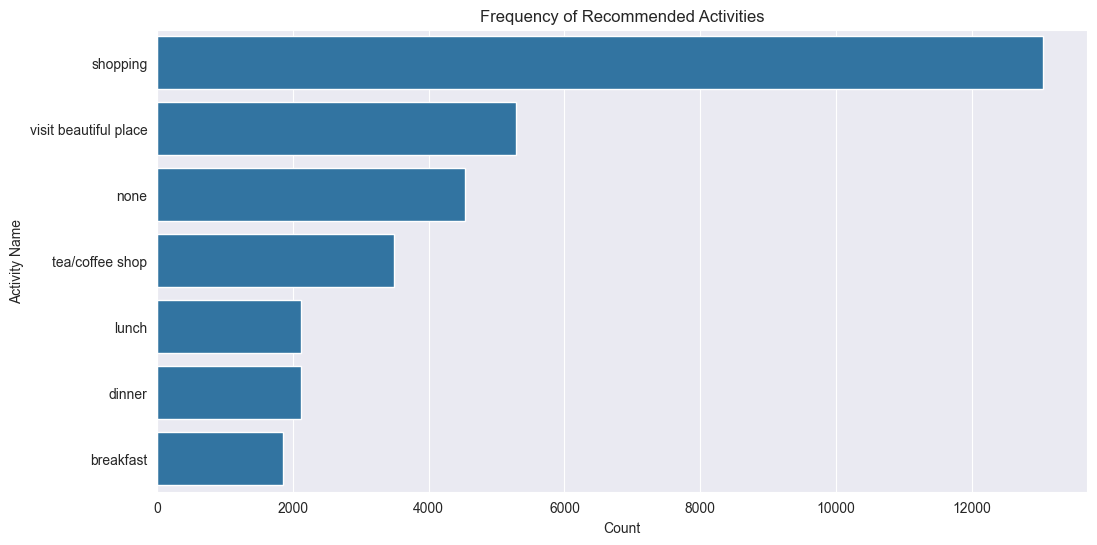

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Split multi-labels to count each activity individually
exploded_labels = df.explode('label')

plt.figure(figsize=(12, 6))
sns.countplot(data=exploded_labels, y='label', order=exploded_labels['label'].value_counts().index)
plt.title('Frequency of Recommended Activities')
plt.xlabel('Count')
plt.ylabel('Activity Name')
plt.show()

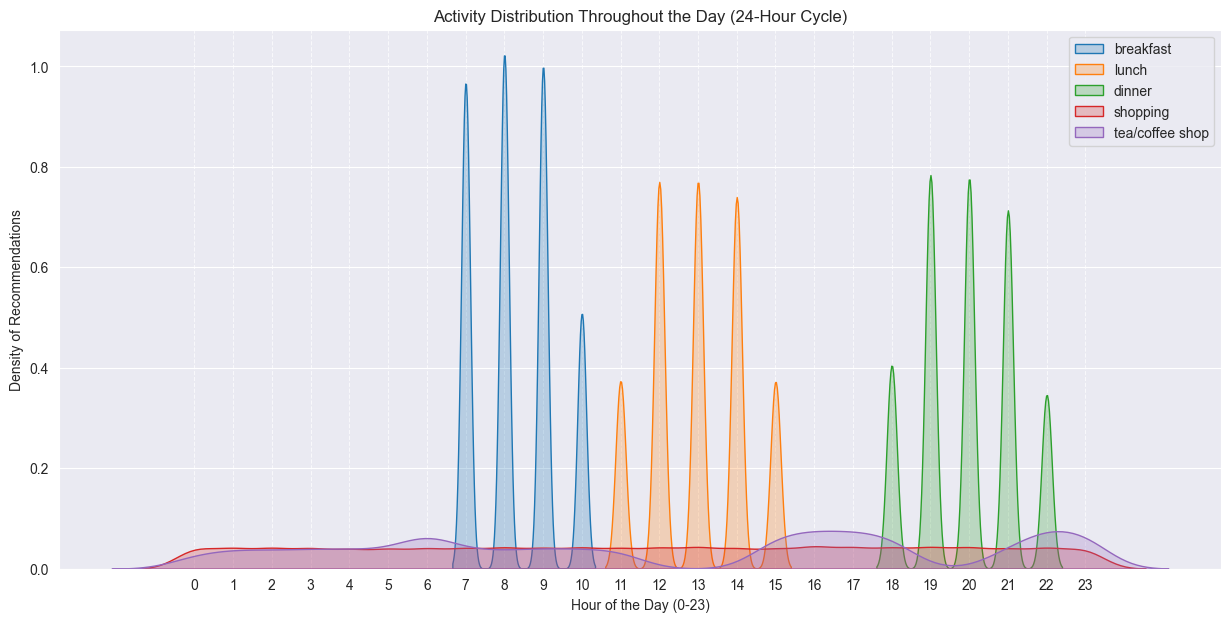

In [6]:
# Create a temporary hour column for visualization
df['hour'] = df['time'].str.split(':').str[0].astype(int)

# Filter for the most common activities to keep the graph clean
top_activities = ['breakfast', 'lunch', 'dinner', 'shopping', 'tea/coffee shop']
df_filtered = exploded_labels[exploded_labels['label'].isin(top_activities)].copy()
df_filtered['hour'] = df_filtered['time'].str.split(':').str[0].astype(int)

# Set the style
plt.figure(figsize=(15, 7))

# Create a KDE plot or Histogram to see the activity flow over 24 hours
for activity in top_activities:
    subset = df_filtered[df_filtered['label'] == activity]
    sns.kdeplot(subset['hour'], label=activity, fill=True, bw_adjust=0.5)

plt.title('Activity Distribution Throughout the Day (24-Hour Cycle)')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Density of Recommendations')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

<Figure size 1500x800 with 0 Axes>

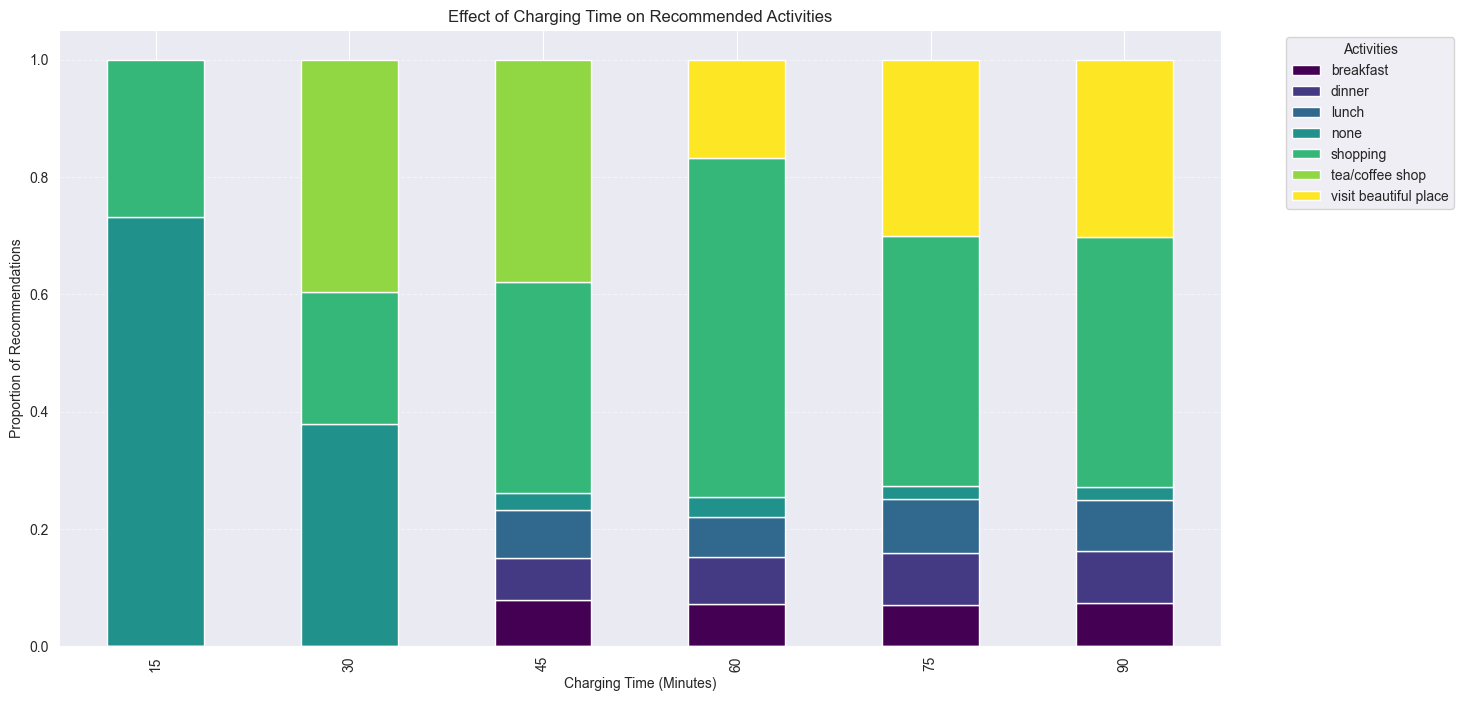

In [7]:
# Create a plot to see how charging_time affects labels
plt.figure(figsize=(15, 8))

# Using the exploded dataframe (where multi-labels are separated)
# We create a cross-tabulation between charging_time and labels
ct = pd.crosstab(exploded_labels['charging_time'], exploded_labels['label'], normalize='index')

# Plotting a stacked bar chart
ct.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='viridis')

plt.title('Effect of Charging Time on Recommended Activities')
plt.xlabel('Charging Time (Minutes)')
plt.ylabel('Proportion of Recommendations')
plt.legend(title='Activities', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [3]:
def transform_features(X_df):
    X_copy = X_df.copy()
    
    # Convert HH:MM time string to total minutes
    time_split = X_copy['time'].str.split(':', expand=True).astype(int)
    X_copy['total_minutes'] = (time_split[0] * 60) + time_split[1]
    
    # Encode 'day' and 'month' columns into numerical codes
    X_copy['day_code'] = pd.factorize(X_copy['day'])[0]
    X_copy['month_code'] = pd.factorize(X_copy['month'])[0]
    
    # Drop original string columns
    return X_copy.drop(['time', 'day', 'month'], axis=1)

# Wrap the function for the Pipeline
feature_transformer = FunctionTransformer(transform_features)

In [4]:
# Initialize Random Forest as the base classifier
rf_base = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)

# Create the MultiOutput Pipeline
model_pipeline = Pipeline([
    ('transformer', feature_transformer),
    ('classifier', MultiOutputClassifier(rf_base))
])

# Start Training
print("Training the model... please wait.")
model_pipeline.fit(X_train, y_train)
print("✅ Training complete!")

Training the model... please wait.
✅ Training complete!


In [5]:
# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluation metrics
print("--- Model Performance Metrics ---")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print(f"Hamming Loss: {hamming_loss(y_test, y_pred):.4f}")
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred, target_names=target_names))

--- Model Performance Metrics ---
Accuracy Score: 0.7488
Hamming Loss: 0.0516

--- Detailed Classification Report ---
                       precision    recall  f1-score   support

            breakfast       0.94      1.00      0.97       357
               dinner       0.96      1.00      0.98       453
                lunch       0.95      1.00      0.97       408
                 none       0.86      0.79      0.83       929
             shopping       0.90      0.89      0.90      2609
      tea/coffee shop       0.92      0.98      0.95       671
visit beautiful place       0.73      0.91      0.81      1100

            micro avg       0.87      0.91      0.89      6527
            macro avg       0.90      0.94      0.91      6527
         weighted avg       0.88      0.91      0.89      6527
          samples avg       0.87      0.89      0.87      6527



C:\Users\malindu\miniconda3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [6]:
# Create a dictionary to store both the model and the label encoder
model_save_package = {
    'pipeline': model_pipeline,
    'mlb': mlb,
    'target_names': target_names
}

# Save the package to a file
joblib.dump(model_save_package, 'ev_recommendation_model.pkl')
print("✅ Model package saved successfully as 'ev_recommendation_model.pkl'")

✅ Model package saved successfully as 'ev_recommendation_model.pkl'


In [7]:
def predict_activity(charging_time, time_str, day, month, is_festival, is_weekend):
    # Prepare input as a DataFrame
    sample_input = pd.DataFrame([{
        'charging_time': charging_time,
        'time': time_str,
        'day': day,
        'month': month,
        'is_festival': is_festival,
        'is_weekend': is_weekend
    }])
    
    # Predict using the saved pipeline
    prediction_binary = model_pipeline.predict(sample_input)
    
    # Transform binary back to labels
    prediction_labels = mlb.inverse_transform(prediction_binary)
    
    return prediction_labels[0]

# --- Example Test ---
# Let's say: 60 mins charge, 1:00 PM (13:00), Monday, January
recommendation = predict_activity(60, "13:00", "Monday", "January", 0, 0)
print(f"Prediction for 13:00 (60 min): {recommendation}")

Prediction for 13:00 (60 min): ('lunch', 'shopping')
